In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from grid2d import Grid2D
from ati.perception.lidar import lidar_pb, lidar_utils
from ati.perception.lidar.lidar_voxel import voxel_filter
from ati.perception.utils.voxel_filter_utils import voxel_filter_fast
from lc_utils import combine_yelli_poses, get_inverse_yelli_pose, imu_pose_estimate, normalize_pose

data [0.1 0.2 1.  0.8 1.  0.1 0.9 0.7 0.4 0.8 0.2 0.2 0.9 0.9 0.9]
unique [0.1 0.2 0.4 0.7 0.8 0.9 1. ]
sorted [0.1 0.1 0.2 0.2 0.2 0.4 0.7 0.8 0.8 0.9 0.9 0.9 0.9 1.  1. ]
indices of unique values [ 0  2  5  6  7  9 13]
argsort [ 0  5  1 10 11  8  7  3  9  6 12 13 14  2  4]


In [2]:
data_dir = "/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1-repeat-32beams/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping/"


In [3]:
map_dir = os.path.join("maps", "5")
with open(os.path.join(map_dir, "submaps-node_poses-inserted_frame_ids_countonce.pickle"), 'rb') as f:
    finished_submaps, node_poses, inserted_frame_ids = pickle.load(f)

(-11.225767128892368,
 115.45215801249205,
 -15.179834279163876,
 159.60958386537877)

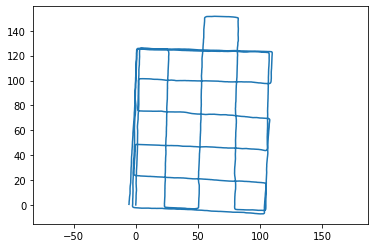

In [4]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
plt.axis('equal')

In [5]:
with open(os.path.join(map_dir, "constraints_oneshot_2.pickle"), 'rb') as f:
    constraints = pickle.load(f)
with open(os.path.join(map_dir, "oposes_2.pickle"), 'rb') as f:
    oposes = pickle.load(f)

<IPython.core.display.Javascript object>


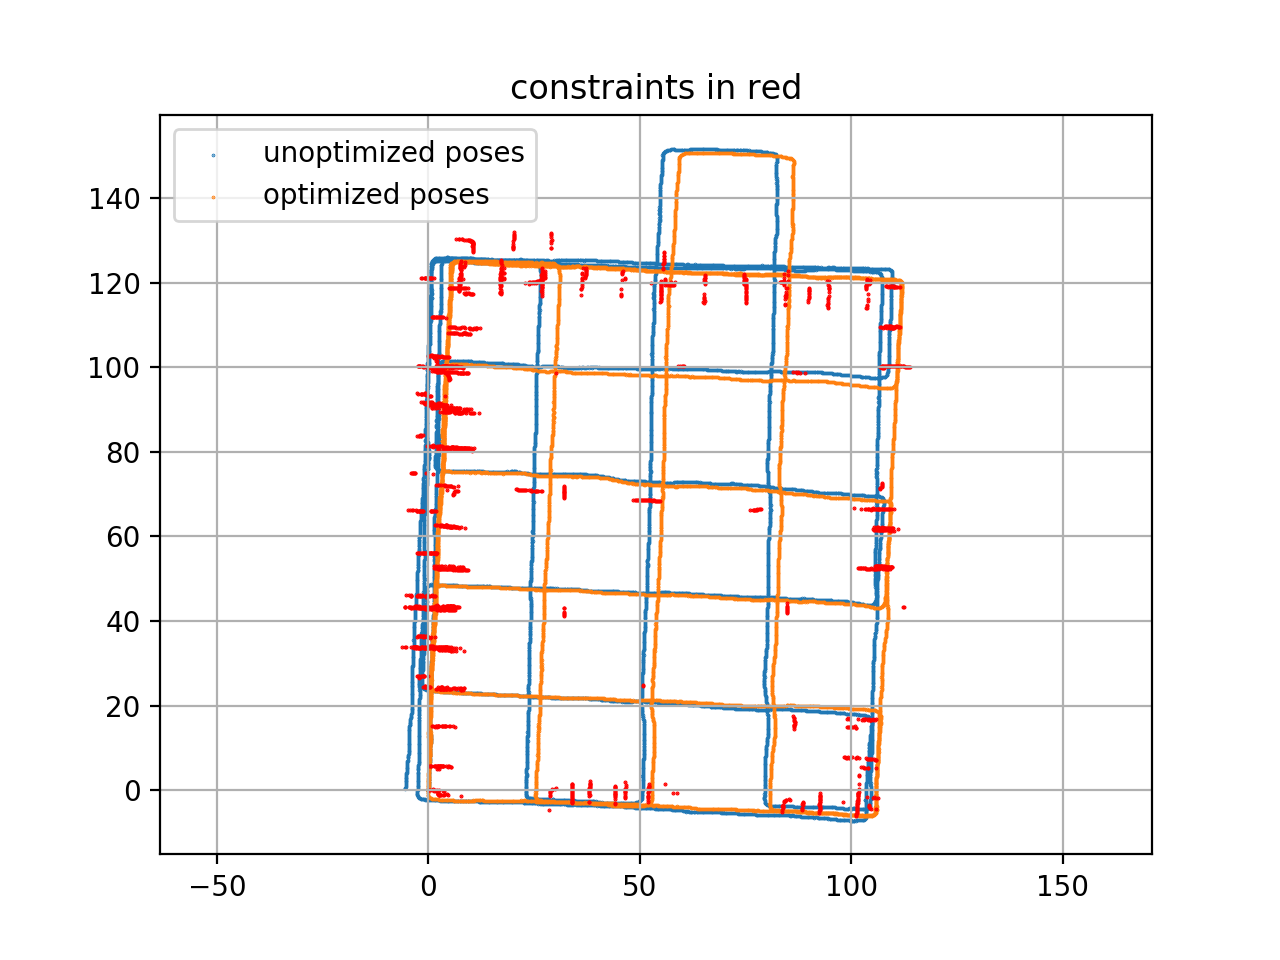

(-12.402746119076966,
 120.0565516629397,
 -15.180304856196638,
 159.61005444241155)

In [20]:
%matplotlib notebook
import numpy as np
plt.figure()
plt.scatter(node_poses[:,0], node_poses[:,1], s=0.1, label = 'unoptimized poses')
plt.scatter(oposes[:,0], oposes[:,1], s=0.1, label = 'optimized poses')
for constraint in constraints:
        nps = oposes[constraint.node_ids[0]]
        cps =combine_yelli_poses(nps, constraint.relative_pose)
        
#         plt.plot([nps[0], cps[0]], [nps[1], cps[1]],'o-', 'g' )
        plt.scatter(cps[0], cps[1], c='r',s=0.2)
plt.title("constraints in red")
plt.legend()
plt.grid()        
plt.axis('equal')

In [7]:
plt.plot(1,2, linewidth=100)

In [25]:
gzmin = 0.75 
gzmax = 1.2
ogrid = Grid2D(grid_alpha =1, grid_res = 0.05)
last_nid = finished_submaps[-1].node_ids[-1]


try:
    lpb = lidar_pb.LidarSmallPb(data_dir)
except:
    lpb = lidar_pb.LidarPb(data_dir)

#for nid in range(len(node_poses)):
for nid in range(last_nid +1):
#     pose = node_poses[nid]
    pose = oposes[nid] + np.array([0,0,np.pi/2])
    fr_id = inserted_frame_ids[nid]
    ts, frame = lpb.get_frame(fr_id)
    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[frame[:,4]>1]
    frame = frame[(frame[:,2] > gzmin) & (frame[:,2] < gzmax)]
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    ogrid.insert_points(pose, frame_z)

In [26]:
def plot_map_new(grid_map, alpha=1.0):
    x1, y1 = -grid_map.origin * grid_map.grid_res
    x2, y2 = (grid_map.grid.shape - grid_map.origin) * grid_map.grid_res
    if grid_map.grid.dtype == np.uint8:
        max_val = 128
    else:
        max_val = 1
#     plt.imshow(
#         max_val - grid_map.grid.T,
#         alpha=alpha,
#         cmap="gray",
#         origin="lower",
#         extent=[x1, x2, y1, y2],
#     )
    plt.imshow(
        1 - (grid_map.grid.T>0),
        alpha=alpha,
        cmap="gray",
        origin="lower",
        extent=[x1, x2, y1, y2],
    )

<IPython.core.display.Javascript object>


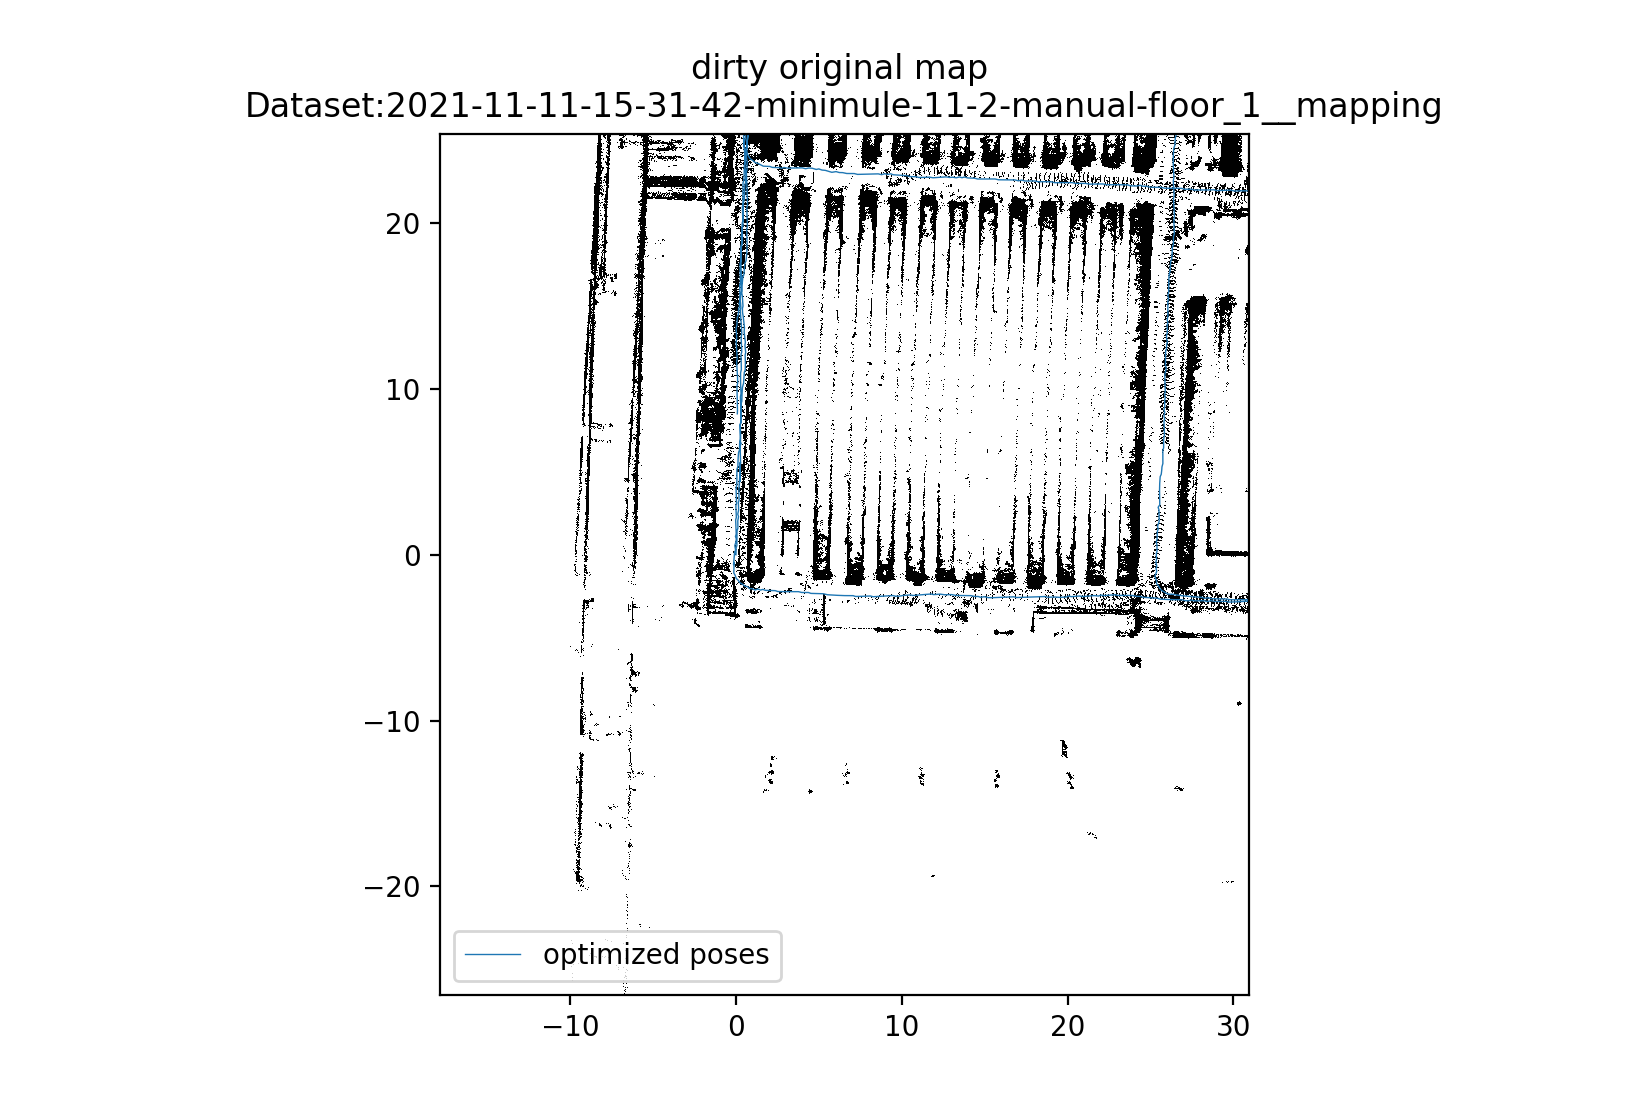

In [27]:
map_name = map_dir
plt.figure()
plot_map_new(ogrid, alpha=2.0)
# plt.plot(node_poses[:,0], node_poses[:,1], label = 'unoptimized poses')
plt.plot(oposes[:,0], oposes[:,1],linewidth=0.5,label = 'optimized poses')
plt.legend()
dataset = data_dir.split("/")[-2]
plt.title(f"dirty original map \nDataset:{dataset}")
plt.savefig(f"{map_name}/yelli_map_unopt_2.png", dpi=1000, bbox_inches="tight")

<IPython.core.display.Javascript object>


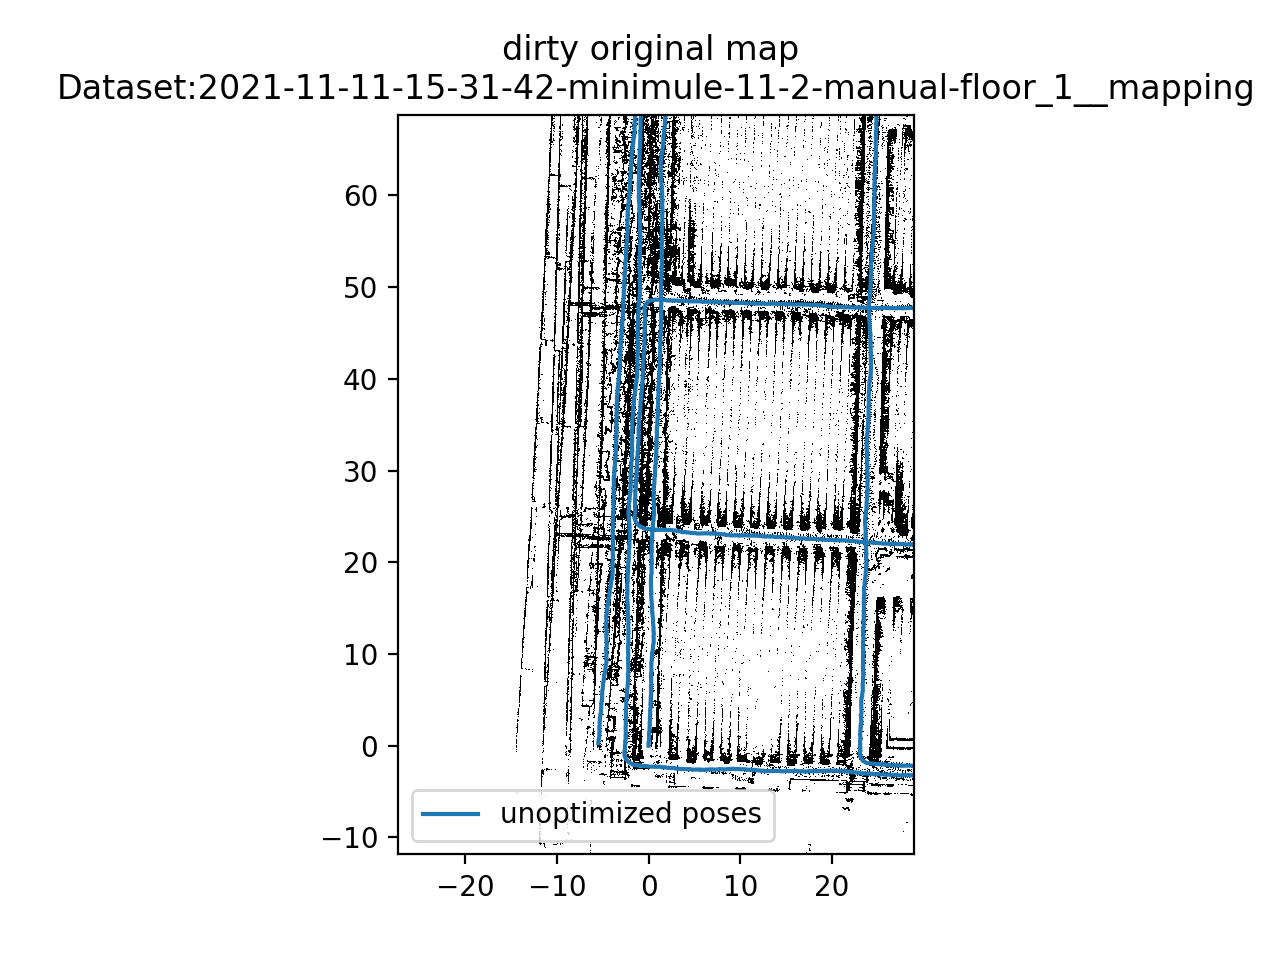

In [21]:
map_name = map_dir
plt.figure()
plot_map_new(ogrid, alpha=2.0)
plt.plot(node_poses[:,0], node_poses[:,1], label = 'unoptimized poses')
# plt.plot(oposes[:,0], oposes[:,1],linewidth=0.5,label = 'optimized poses')
plt.legend()
dataset = data_dir.split("/")[-2]
plt.title(f"dirty original map \nDataset:{dataset}")
plt.savefig(f"{map_name}/yelli_map_unopt_2.png", dpi=1000, bbox_inches="tight")

In [22]:
node_poses

array([[ 0.        ,  0.        ,  1.57079633],
       [ 0.        ,  0.        ,  1.57079633],
       [ 0.        ,  0.        ,  1.57079633],
       ...,
       [-5.45846552,  0.62459149, -1.63341974],
       [-5.46767962,  0.47452319, -1.63157217],
       [-5.48015581,  0.27491281, -1.63461761]])

In [23]:
import pickle

with open("maps/5/submaps-node_poses-inserted_frame_ids_countonce.pickle", 'wb') as f:
    pickle.dump((finished_submaps, node_poses, inserted_frame_ids),f)

In [24]:
import pickle
with open("./maps/5/constraints_oneshot_3.pickle", 'wb') as f:
    pickle.dump(constraints,f)